In [22]:
from datasets import load_dataset
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import Counter
import os
import io
import time

In [2]:
ds = load_dataset("ds4sd/FinTabNet_OTSL")
print('dataset')
print(ds)

train_sample = ds['train'][0]

#cells, otsl,html

print(len(train_sample["cells"]))
print(len(train_sample["otsl"]))
print(len(train_sample["html"]))
print(type(train_sample['image']))
print(train_sample)

dataset
DatasetDict({
    train: Dataset({
        features: ['filename', 'split', 'imgid', 'dataset', 'cells', 'otsl', 'html', 'html_restored', 'cols', 'rows', 'html_len', 'otsl_len', 'image'],
        num_rows: 88441
    })
    test: Dataset({
        features: ['filename', 'split', 'imgid', 'dataset', 'cells', 'otsl', 'html', 'html_restored', 'cols', 'rows', 'html_len', 'otsl_len', 'image'],
        num_rows: 10397
    })
    val: Dataset({
        features: ['filename', 'split', 'imgid', 'dataset', 'cells', 'otsl', 'html', 'html_restored', 'cols', 'rows', 'html_len', 'otsl_len', 'image'],
        num_rows: 10505
    })
})
1
42
84
<class 'PIL.PngImagePlugin.PngImageFile'>
{'filename': 'MDT.2018.page_32.pdf_1.png', 'split': 'train', 'imgid': 1, 'dataset': 'ftn', 'cells': [[{'tokens': ['L', 'o', 'c', 'a', 't', 'i', 'o', 'n', ' ', 'C', 'o', 'u', 'n', 't', 'r', 'y', ' ', 'o', 'r', ' ', 'S', 't', 'a', 't', 'e'], 'bbox': [-1, 1, 88, 9, 2]}, {'tokens': ['S', 'q', 'u', 'a', 'r', 'e', ' ', '

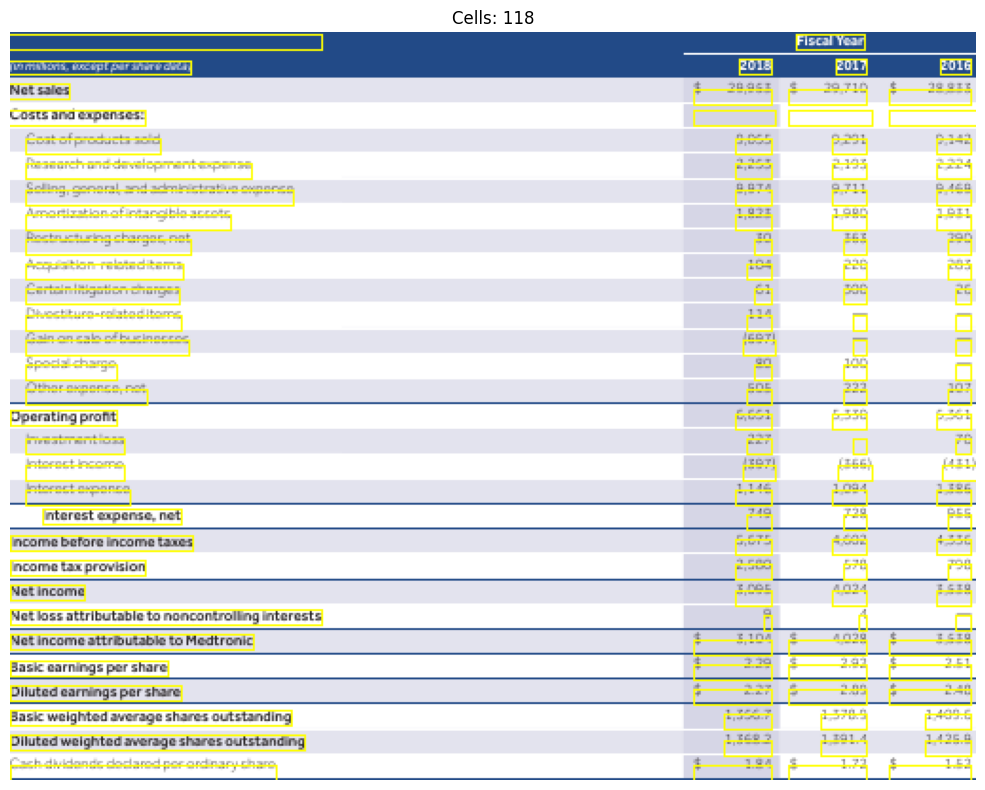

In [3]:
def vis_cells(sample):
    cells_flat = sample['cells'][0]
    img = sample['image']
    
    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)
    
    # draw all cell bboxes
    for cell in cells_flat:
        bbox = cell['bbox'][:4]
        draw.rectangle(bbox, outline='yellow', width=1)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_copy)
    plt.title(f'Cells: {len(cells_flat)}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

vis_cells(ds['train'][10])

In [4]:
def print_grid(grid):
    num_cols = max(len(row) for row in grid)
    col_width = 6
    
    # Top border
    print('+' + '+'.join(['-' * col_width for _ in range(num_cols)]) + '+')
    
    # Each row
    for row in grid:
        row_str = '|'
        for cell in row:
            cell_type = cell['type']
            row_str += cell_type.center(col_width) + '|'
        # Pad if row is shorter
        for _ in range(num_cols - len(row)):
            row_str += ' ' * col_width + '|'
        print(row_str)
        print('+' + '+'.join(['-' * col_width for _ in range(num_cols)]) + '+')



In [5]:
sample = ds['train'][10]
cells_flat = sample['cells'][0]
otsl = sample['otsl']
img = sample['image']

for cell in cells_flat[:2]:
    print('text:',"".join(cell['tokens']),",",cell['bbox'])

for x in otsl[:4]:
    print(x,end=',')

print()
print(len(cells_flat))
print(Counter(otsl))



text:  , [-1, 1, 164, 9, 1]
text: Fiscal Year , [414, 1, 450, 9, 2]
ecel,fcel,lcel,lcel,
118
Counter({'fcel': 114, 'nl': 30, 'ecel': 4, 'lcel': 2})


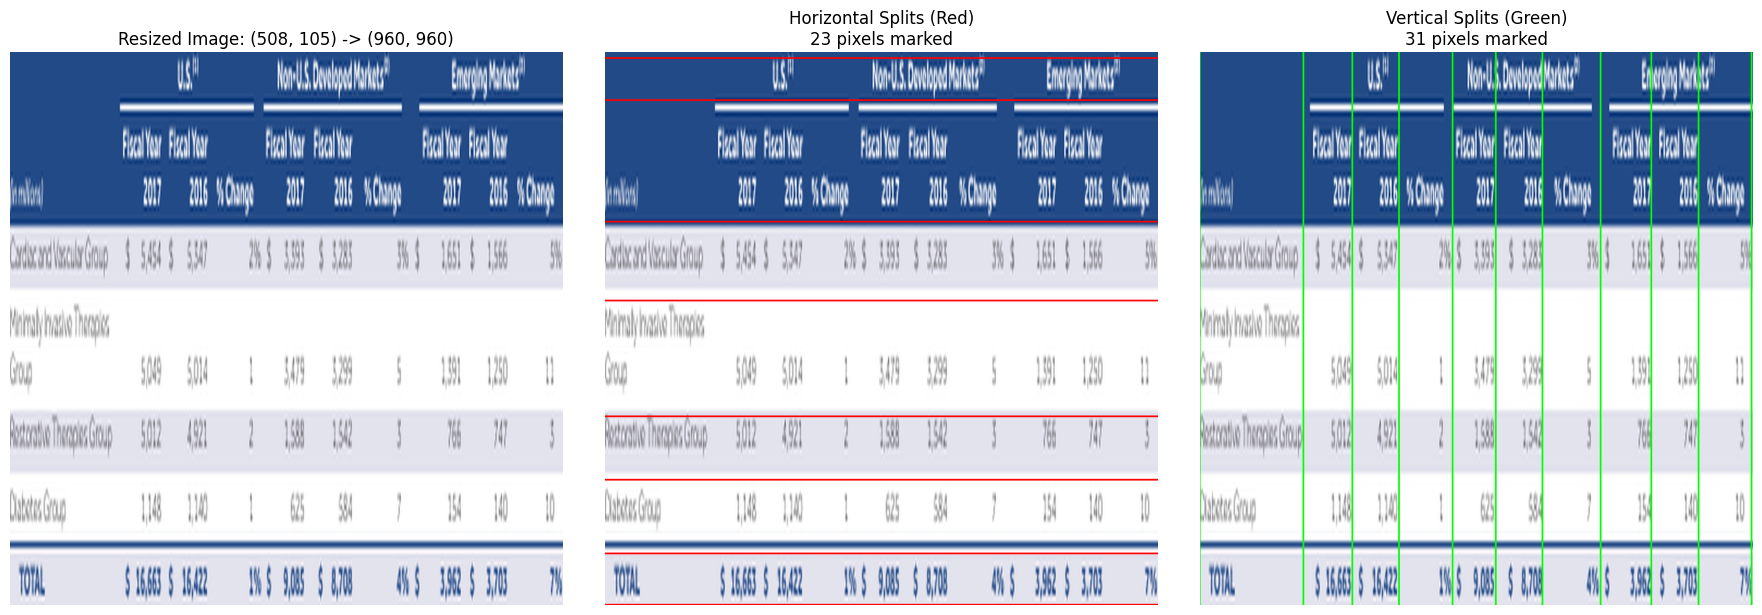

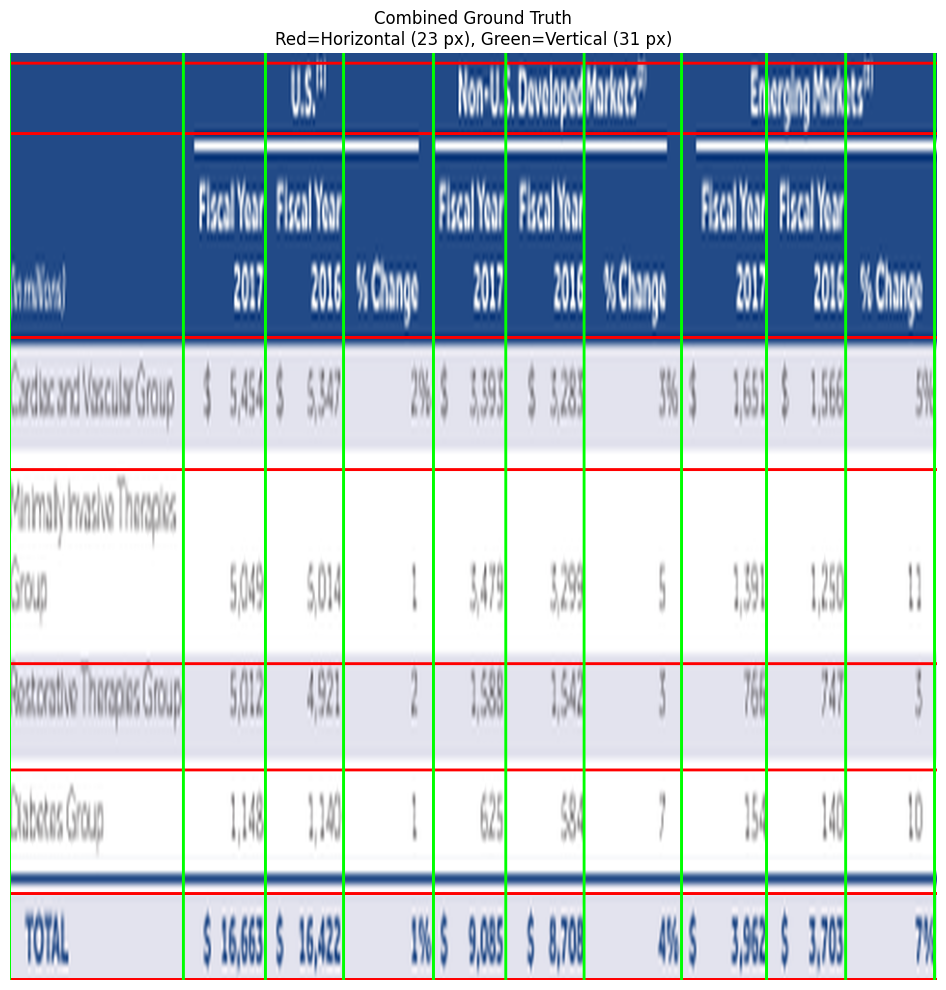

In [66]:

def get_ground_truth(image, cells, otsl, split_width=5):

    """
    parse OTSL to derive row/column split positions.
    this is the groundtruth for split model training.

    Args:
        image: PIL Image
        html_tags: not used, kept for compatibility
        cells: nested list - cells[0] contains actual cell data
        otsl: OTSL token sequence
        split_width: width of split regions in pixels (default: 5)
    """
    orig_width, orig_height = image.size
    target_size = 960
    
    # cells is nested - extract actual list
    cells_flat = cells[0]
    
    # parse OTSL to build 2D grid
    grid = []
    current_row = []
    cell_idx = 0  # only increments for fcel ,ecel tokens
    
    for token in otsl:
        if token == 'nl':
            if current_row:
                grid.append(current_row)
                current_row = []
        elif token == 'fcel' or token=='ecel':
            current_row.append({'type': token, 'cell_idx': cell_idx})
            cell_idx += 1
        elif token in ['lcel', 'ucel', 'xcel']:
            # merge/empty tokens don't consume bboxes
            current_row.append({'type': token, 'cell_idx': None})
    
    if current_row:
        grid.append(current_row)
    
    # derive row splits - max y2 for each row
    row_splits = []
    for row in grid:
        row_cell_indices = [item['cell_idx'] for item in row if item['cell_idx'] is not None]
        if row_cell_indices:
            max_y = max(cells_flat[i]['bbox'][3] for i in row_cell_indices)
            row_splits.append(max_y)
    
    # derive column splits - max x2 for each column
    num_cols = len(grid[0]) if grid else 0
    col_splits = []
    for col_idx in range(num_cols):
        col_max_x = []
        for row in grid:
            if col_idx < len(row) and row[col_idx]['cell_idx'] is not None:
                next_is_lcel = (col_idx + 1 < len(row) and row[col_idx + 1]['type'] == 'lcel')
                if not next_is_lcel:
                    cell_id = row[col_idx]['cell_idx']
                    col_max_x.append(cells_flat[cell_id]['bbox'][2])
        if col_max_x:
            col_splits.append(max(col_max_x))

    # # DEBUG: print what we found
    # print(f"\nDEBUG get_ground_truth:")
    # print(f"  Found {len(row_splits)} row splits: {row_splits}")
    # print(f"  Found {len(col_splits)} col splits: {col_splits}")
    
    # # scale to target size
    # y_scaled = [(y * target_size / orig_height) for y in row_splits]
    # x_scaled = [(x * target_size / orig_width) for x in col_splits]
    
    # print(f"  Scaled row splits: {[int(y) for y in y_scaled]}")
    # print(f"  Scaled col splits: {[int(x) for x in x_scaled]}")

    
    row_splits = row_splits[:-1]
    col_splits = col_splits[:-1]

    # scale to target size
    y_scaled = [(y * target_size / orig_height) for y in row_splits]
    x_scaled = [(x * target_size / orig_width) for x in col_splits]
    
    # init ground truth arrays
    horizontal_gt = [0] * target_size
    vertical_gt = [0] * target_size

    all_x1 = [c['bbox'][0] for c in cells_flat]
    all_y1 = [c['bbox'][1] for c in cells_flat]
    all_x2 = [c['bbox'][2] for c in cells_flat]
    all_y2 = [c['bbox'][3] for c in cells_flat]
    table_bbox = [min(all_x1), min(all_y1), max(all_x2), max(all_y2)]
    table_y1 = int(round(table_bbox[1] * target_size / orig_height))
    table_y2 = int(round(table_bbox[3] * target_size / orig_height))
    table_x1 = int(round(table_bbox[0] * target_size / orig_width))
    table_x2 = int(round(table_bbox[2] * target_size / orig_width))


    # Mark table bbox boundaries (5 pixels wide)
    # Top boundary
    for offset in range(split_width):
        pos = table_y1 + offset
        if 0 <= pos < target_size:
            horizontal_gt[pos] = 1

    # Bottom boundary
    for offset in range(split_width):
        pos = table_y2 - offset
        if 0 <= pos < target_size:
            horizontal_gt[pos] = 1

    # Left boundary
    for offset in range(split_width):
        pos = table_x1 + offset
        if 0 <= pos < target_size:
            vertical_gt[pos] = 1

    # Right boundary
    for offset in range(split_width):
        pos = table_x2 - offset
        if 0 <= pos < target_size:
            vertical_gt[pos] = 1

    # mark split regions (configurable pixel width)
    for y in y_scaled:
        y_int = int(round(y))
        if 0 <= y_int < target_size:
            for offset in range(split_width):
                pos = y_int + offset
                if 0 <= pos < target_size:
                    horizontal_gt[pos] = 1

    for x in x_scaled:
        x_int = int(round(x))
        if 0 <= x_int < target_size:
            for offset in range(split_width):
                pos = x_int + offset
                if 0 <= pos < target_size:
                    vertical_gt[pos] = 1
    
    return horizontal_gt, vertical_gt



import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

def visualize_ground_truth(sample, target_size=960,split_width=5):
    """
    Visualize ground truth splits overlaid on the image.
    
    Args:
        sample: dataset sample with 'image', 'cells', 'otsl' keys
        target_size: target dimension for ground truth (default 960)
    """
    # Get ground truth
    horizontal_gt, vertical_gt = get_ground_truth(sample['image'],sample['cells'],sample['otsl'],split_width=split_width)
    
    # Get and resize image
    img = sample['image']
    img_resized = img.resize((target_size, target_size), Image.LANCZOS)
    
    # Convert to numpy for visualization
    img_array = np.array(img_resized)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Original resized image
    axes[0].imshow(img_resized)
    axes[0].set_title(f'Resized Image: {img.size} -> {img_resized.size}')
    axes[0].axis('off')
    
    # 2. Image with horizontal splits overlay
    img_h = img_array.copy()
    for y_pos, val in enumerate(horizontal_gt):
        if val == 1:
            img_h[y_pos, :] = [255, 0, 0]  # Red horizontal lines
    
    axes[1].imshow(img_h)
    axes[1].set_title(f'Horizontal Splits (Red)\n{sum(horizontal_gt)} pixels marked')
    axes[1].axis('off')
    
    # 3. Image with vertical splits overlay
    img_v = img_array.copy()
    for x_pos, val in enumerate(vertical_gt):
        if val == 1:
            img_v[:, x_pos] = [0, 255, 0]  # Green vertical lines
    
    axes[2].imshow(img_v)
    axes[2].set_title(f'Vertical Splits (Green)\n{sum(vertical_gt)} pixels marked')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Also create a combined view
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    img_combined = img_array.copy()
    
    # Overlay both splits
    for y_pos, val in enumerate(horizontal_gt):
        if val == 1:
            img_combined[y_pos, :] = [255, 0, 0]  # Red
    
    for x_pos, val in enumerate(vertical_gt):
        if val == 1:
            img_combined[:, x_pos] = [0, 255, 0]  # Green
    
    ax.imshow(img_combined)
    ax.set_title(f'Combined Ground Truth\nRed=Horizontal ({sum(horizontal_gt)} px), Green=Vertical ({sum(vertical_gt)} px)')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# # Test the visualization
# for i in range(100):
#     clear_output(wait=True)
#     visualize_ground_truth(ds['train'][i])
#     time.sleep(1)

visualize_ground_truth(ds['train'][3],split_width=3)



## Dense ones lines

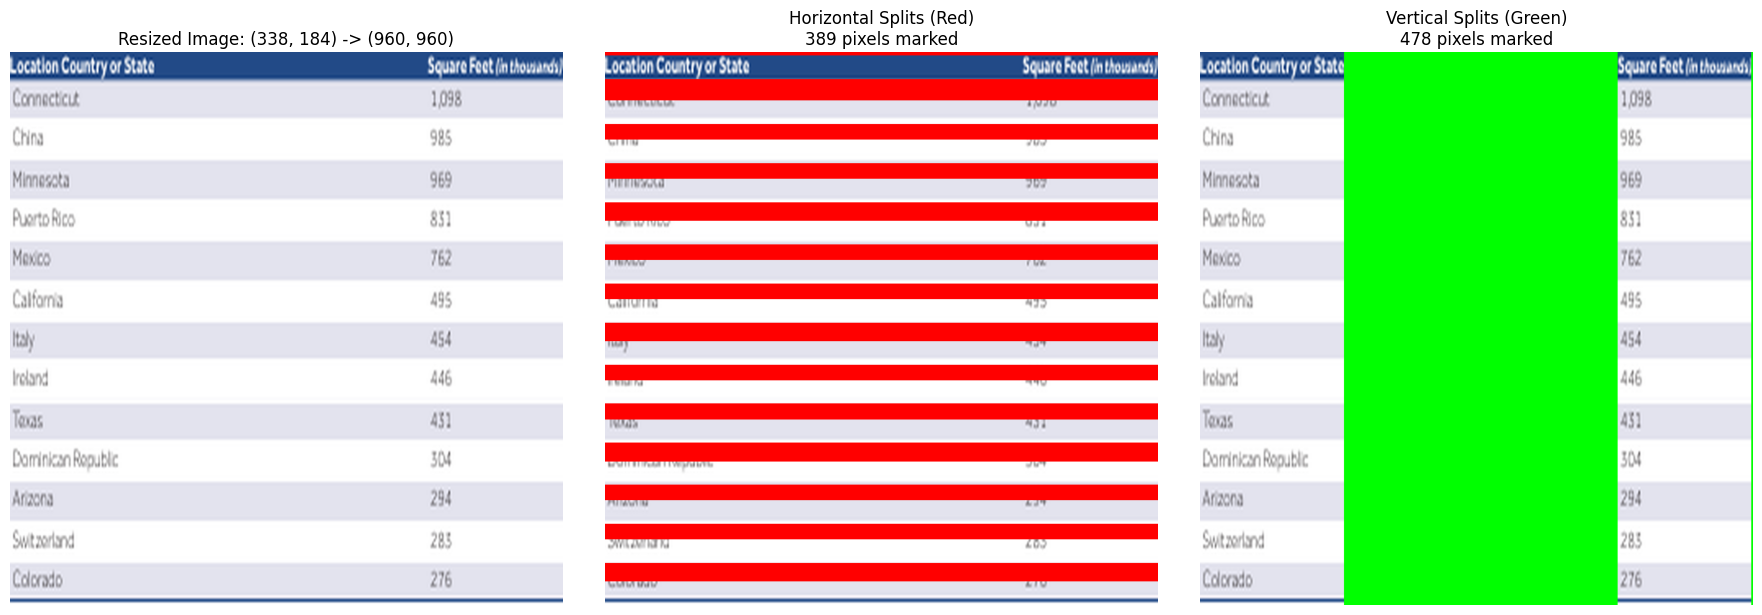

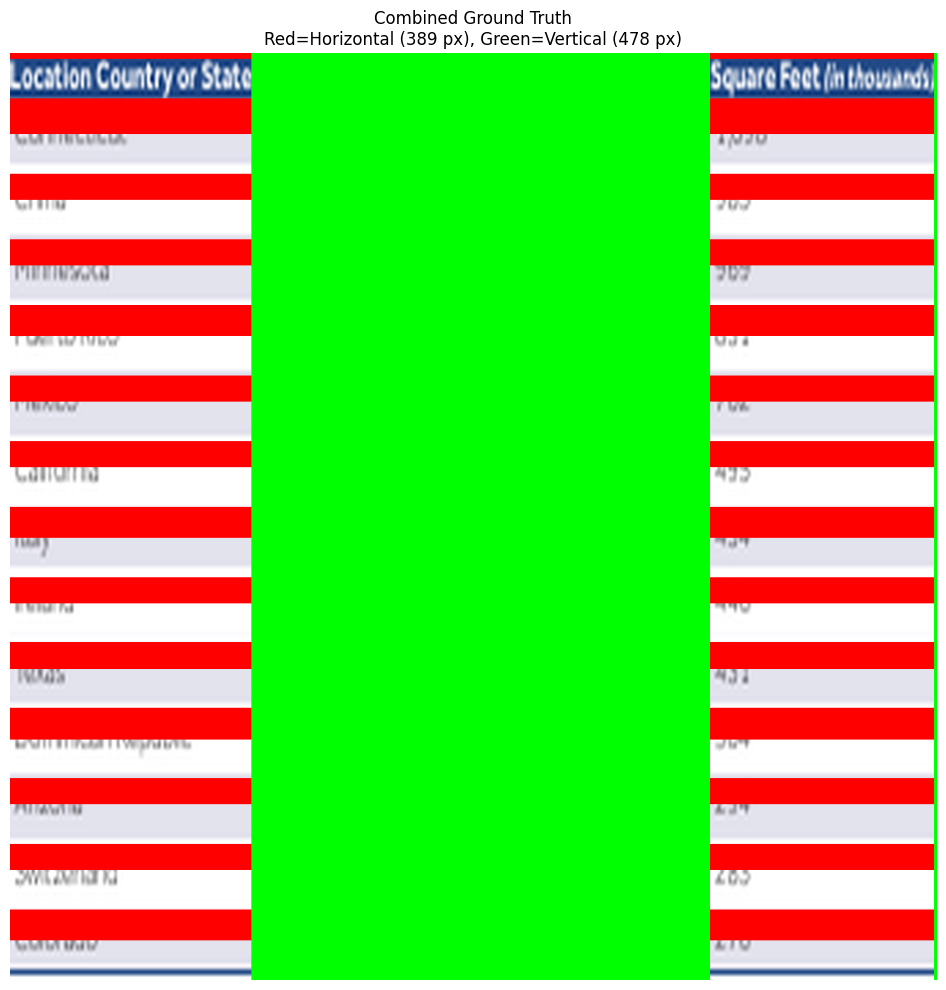

In [ ]:

def get_ground_truth(image, cells, otsl):
    """
    parse OTSL to derive row/column split positions.
    this is the groundtruth for split model training.
    Now uses DYNAMIC gap filling instead of fixed split_width.

    Args:
        image: PIL Image
        cells: nested list - cells[0] contains actual cell data
        otsl: OTSL token sequence
    """
    orig_width, orig_height = image.size
    target_size = 960
    
    # cells is nested - extract actual list
    cells_flat = cells[0]
    
    # parse OTSL to build 2D grid
    grid = []
    current_row = []
    cell_idx = 0  # only increments for fcel, ecel tokens
    
    for token in otsl:
        if token == 'nl':
            if current_row:
                grid.append(current_row)
                current_row = []
        elif token == 'fcel' or token == 'ecel':
            current_row.append({'type': token, 'cell_idx': cell_idx})
            cell_idx += 1
        elif token in ['lcel', 'ucel', 'xcel']:
            # merge/empty tokens don't consume bboxes
            current_row.append({'type': token, 'cell_idx': None})
    
    if current_row:
        grid.append(current_row)
    
    # Get row boundaries (min_y1 and max_y2 for each row)
    row_boundaries = []
    for row in grid:
        row_cell_indices = [item['cell_idx'] for item in row if item['cell_idx'] is not None]
        if row_cell_indices:
            min_y = min(cells_flat[i]['bbox'][1] for i in row_cell_indices)
            max_y = max(cells_flat[i]['bbox'][3] for i in row_cell_indices)
            row_boundaries.append({'min_y': min_y, 'max_y': max_y})
    
    # Get column boundaries (min_x1 and max_x2 for each column)
    num_cols = len(grid[0]) if grid else 0
    col_boundaries = []
    for col_idx in range(num_cols):
        col_cells = []
        for row in grid:
            if col_idx < len(row) and row[col_idx]['cell_idx'] is not None:
                # Check if next cell is lcel (merged left)
                next_is_lcel = (col_idx + 1 < len(row) and row[col_idx + 1]['type'] == 'lcel')
                if not next_is_lcel:
                    cell_id = row[col_idx]['cell_idx']
                    col_cells.append(cell_id)
        if col_cells:
            min_x = min(cells_flat[i]['bbox'][0] for i in col_cells)
            max_x = max(cells_flat[i]['bbox'][2] for i in col_cells)
            col_boundaries.append({'min_x': min_x, 'max_x': max_x})
    
    # Calculate table bbox
    all_x1 = [c['bbox'][0] for c in cells_flat]
    all_y1 = [c['bbox'][1] for c in cells_flat]
    all_x2 = [c['bbox'][2] for c in cells_flat]
    all_y2 = [c['bbox'][3] for c in cells_flat]
    table_bbox = [min(all_x1), min(all_y1), max(all_x2), max(all_y2)]
    
    # Init ground truth arrays
    horizontal_gt = [0] * target_size
    vertical_gt = [0] * target_size
    
    # Helper function to scale and mark range
    def mark_range(gt_array, start, end, orig_dim):
        start_scaled = int(round(start * target_size / orig_dim))
        end_scaled = int(round(end * target_size / orig_dim))
        for pos in range(start_scaled, end_scaled + 1):
            if 0 <= pos < target_size:
                gt_array[pos] = 1
    
    # Mark HORIZONTAL gaps (between rows)
    # 1. Gap from image top to table top
    if row_boundaries:
        mark_range(horizontal_gt, 0, row_boundaries[0]['min_y'], orig_height)
    
    # 2. Gaps between consecutive rows
    for i in range(len(row_boundaries) - 1):
        gap_start = row_boundaries[i]['max_y']
        gap_end = row_boundaries[i + 1]['min_y']
        mark_range(horizontal_gt, gap_start, gap_end, orig_height)
    
    # 3. Gap from table bottom to image bottom
    if row_boundaries:
        mark_range(horizontal_gt, row_boundaries[-1]['max_y'], orig_height, orig_height)
    
    # Mark VERTICAL gaps (between columns)
    # 1. Gap from image left to table left
    if col_boundaries:
        mark_range(vertical_gt, 0, col_boundaries[0]['min_x'], orig_width)
    
    # 2. Gaps between consecutive columns
    for i in range(len(col_boundaries) - 1):
        gap_start = col_boundaries[i]['max_x']
        gap_end = col_boundaries[i + 1]['min_x']
        mark_range(vertical_gt, gap_start, gap_end, orig_width)
    
    # 3. Gap from table right to image right
    if col_boundaries:
        mark_range(vertical_gt, col_boundaries[-1]['max_x'], orig_width, orig_width)
    
    return horizontal_gt, vertical_gt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

def visualize_ground_truth(sample, target_size=960,split_width=5):
    """
    Visualize ground truth splits overlaid on the image.
    
    Args:
        sample: dataset sample with 'image', 'cells', 'otsl' keys
        target_size: target dimension for ground truth (default 960)
    """
    # Get ground truth
    horizontal_gt, vertical_gt = get_ground_truth(sample['image'],sample['cells'],sample['otsl'])
    
    # Get and resize image
    img = sample['image']
    img_resized = img.resize((target_size, target_size), Image.LANCZOS)
    
    # Convert to numpy for visualization
    img_array = np.array(img_resized)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Original resized image
    axes[0].imshow(img_resized)
    axes[0].set_title(f'Resized Image: {img.size} -> {img_resized.size}')
    axes[0].axis('off')
    
    # 2. Image with horizontal splits overlay
    img_h = img_array.copy()
    for y_pos, val in enumerate(horizontal_gt):
        if val == 1:
            img_h[y_pos, :] = [255, 0, 0]  # Red horizontal lines
    
    axes[1].imshow(img_h)
    axes[1].set_title(f'Horizontal Splits (Red)\n{sum(horizontal_gt)} pixels marked')
    axes[1].axis('off')
    
    # 3. Image with vertical splits overlay
    img_v = img_array.copy()
    for x_pos, val in enumerate(vertical_gt):
        if val == 1:
            img_v[:, x_pos] = [0, 255, 0]  # Green vertical lines
    
    axes[2].imshow(img_v)
    axes[2].set_title(f'Vertical Splits (Green)\n{sum(vertical_gt)} pixels marked')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Also create a combined view
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    img_combined = img_array.copy()
    
    # Overlay both splits
    for y_pos, val in enumerate(horizontal_gt):
        if val == 1:
            img_combined[y_pos, :] = [255, 0, 0]  # Red
    
    for x_pos, val in enumerate(vertical_gt):
        if val == 1:
            img_combined[:, x_pos] = [0, 255, 0]  # Green
    
    ax.imshow(img_combined)
    ax.set_title(f'Combined Ground Truth\nRed=Horizontal ({sum(horizontal_gt)} px), Green=Vertical ({sum(vertical_gt)} px)')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# # Test the visualization
# for i in range(100):
#     clear_output(wait=True)
#     visualize_ground_truth(ds['train'][i])
#     time.sleep(1)

visualize_ground_truth(ds['train'][0])



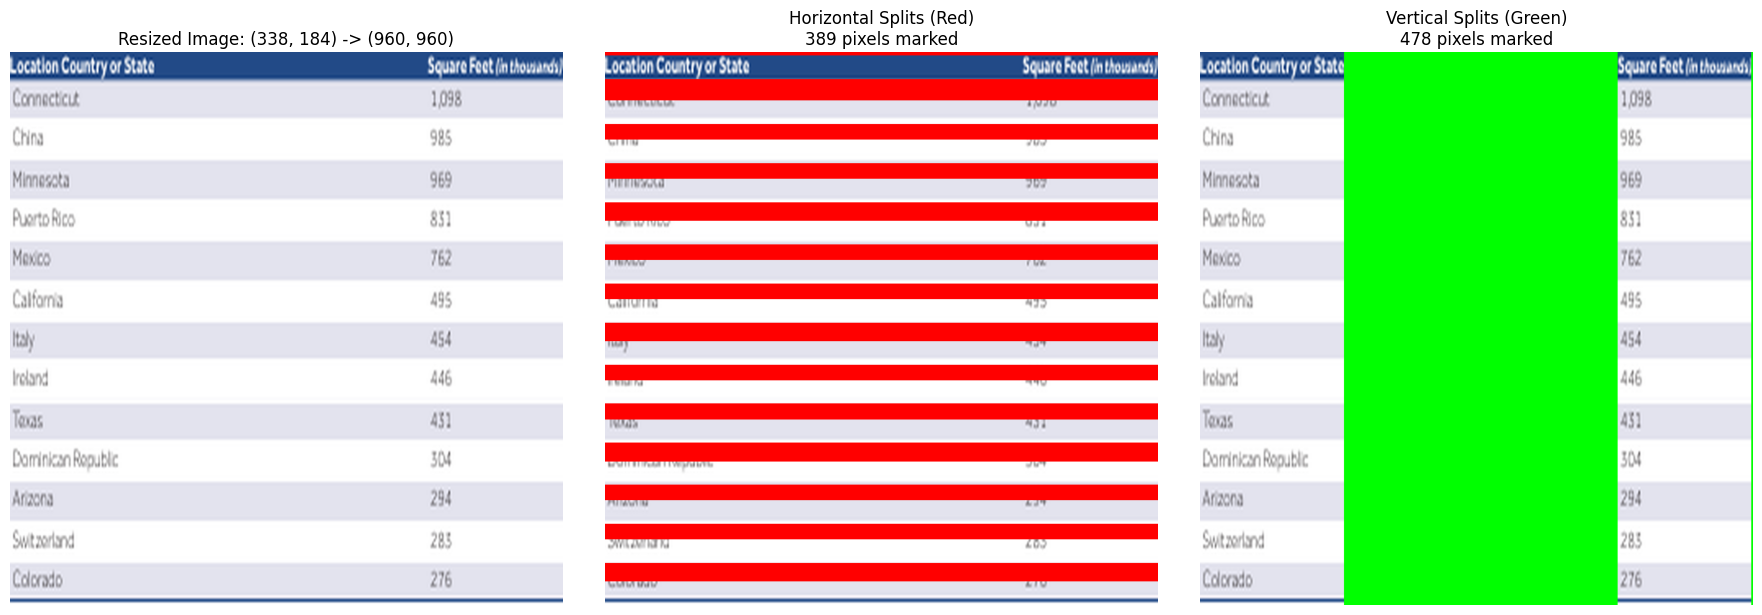

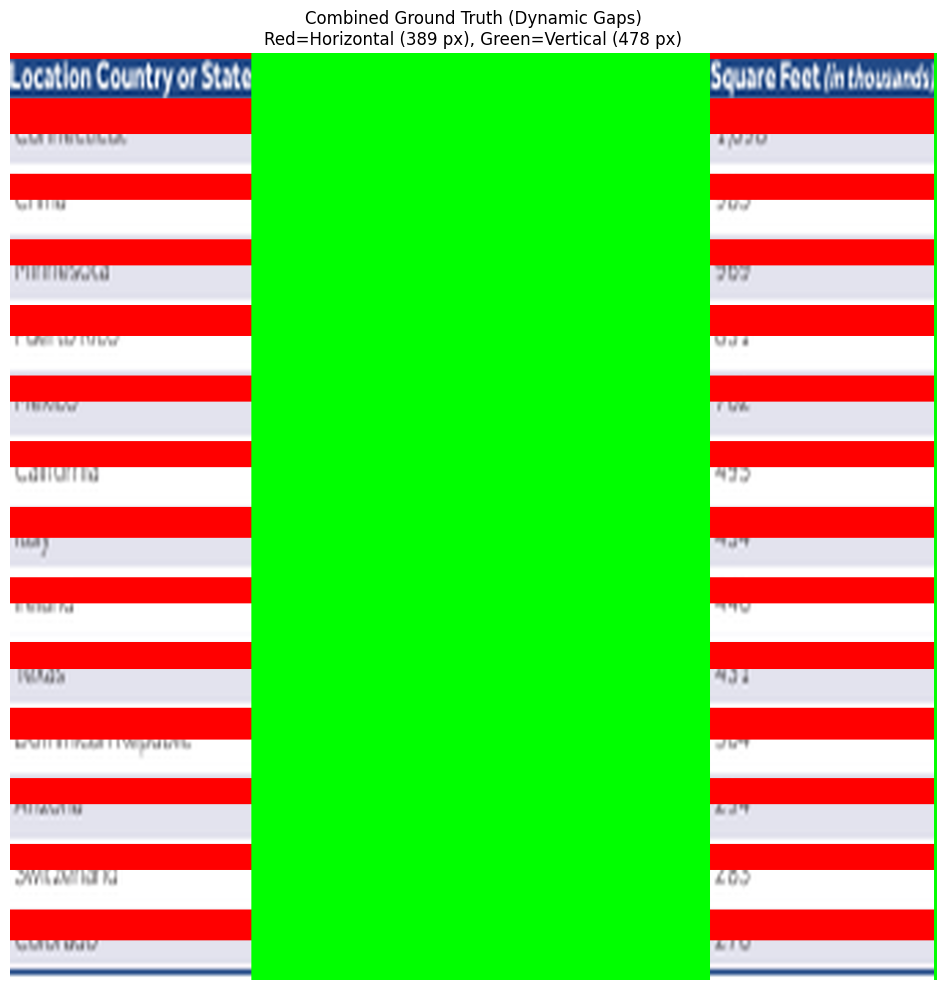

In [71]:
def get_ground_truth(image, cells, otsl):
    """
    Parse OTSL to derive row/column split positions with DYNAMIC gap widths.
    This creates ground truth for the split model training.

    Args:
        image: PIL Image
        cells: nested list - cells[0] contains actual cell data
        otsl: OTSL token sequence
    """
    orig_width, orig_height = image.size
    target_size = 960
    
    # cells is nested - extract actual list
    cells_flat = cells[0]
    
    # Parse OTSL to build 2D grid
    grid = []
    current_row = []
    cell_idx = 0  # only increments for fcel, ecel tokens
    
    for token in otsl:
        if token == 'nl':
            if current_row:
                grid.append(current_row)
                current_row = []
        elif token == 'fcel' or token == 'ecel':
            current_row.append({'type': token, 'cell_idx': cell_idx})
            cell_idx += 1
        elif token in ['lcel', 'ucel', 'xcel']:
            # merge/empty tokens don't consume bboxes
            current_row.append({'type': token, 'cell_idx': None})
    
    if current_row:
        grid.append(current_row)
    
    # Get row boundaries (min y1 and max y2 for each row)
    row_boundaries = []
    for row in grid:
        row_cell_indices = [item['cell_idx'] for item in row if item['cell_idx'] is not None]
        if row_cell_indices:
            min_y1 = min(cells_flat[i]['bbox'][1] for i in row_cell_indices)
            max_y2 = max(cells_flat[i]['bbox'][3] for i in row_cell_indices)
            row_boundaries.append({'min_y': min_y1, 'max_y': max_y2})
    
    # Get column boundaries (min x1 and max x2 for each column)
    num_cols = len(grid[0]) if grid else 0
    col_boundaries = []
    for col_idx in range(num_cols):
        col_cells = []
        for row in grid:
            if col_idx < len(row) and row[col_idx]['cell_idx'] is not None:
                # Check if next cell is lcel (merged left)
                next_is_lcel = (col_idx + 1 < len(row) and row[col_idx + 1]['type'] == 'lcel')
                if not next_is_lcel:
                    cell_id = row[col_idx]['cell_idx']
                    col_cells.append(cell_id)
        if col_cells:
            min_x1 = min(cells_flat[i]['bbox'][0] for i in col_cells)
            max_x2 = max(cells_flat[i]['bbox'][2] for i in col_cells)
            col_boundaries.append({'min_x': min_x1, 'max_x': max_x2})
    
    # Calculate table bbox
    all_x1 = [c['bbox'][0] for c in cells_flat]
    all_y1 = [c['bbox'][1] for c in cells_flat]
    all_x2 = [c['bbox'][2] for c in cells_flat]
    all_y2 = [c['bbox'][3] for c in cells_flat]
    table_bbox = [min(all_x1), min(all_y1), max(all_x2), max(all_y2)]
    
    # Init ground truth arrays
    horizontal_gt = [0] * target_size
    vertical_gt = [0] * target_size
    
    # Helper function to scale and mark range
    def mark_range(gt_array, start, end, orig_dim):
        """Mark all pixels from start to end (scaled to target_size)"""
        start_scaled = int(round(start * target_size / orig_dim))
        end_scaled = int(round(end * target_size / orig_dim))
        for pos in range(start_scaled, min(end_scaled + 1, target_size)):
            if 0 <= pos < target_size:
                gt_array[pos] = 1
    
    # Mark HORIZONTAL gaps (between rows)
    # 1. Gap from image top to first row top
    if row_boundaries:
        mark_range(horizontal_gt, 0, row_boundaries[0]['min_y'], orig_height)
    
    # 2. Gaps between consecutive rows
    for i in range(len(row_boundaries) - 1):
        gap_start = row_boundaries[i]['max_y']
        gap_end = row_boundaries[i + 1]['min_y']
        if gap_end > gap_start:  # Only mark if there's actual gap
            mark_range(horizontal_gt, gap_start, gap_end, orig_height)
    
    # 3. Gap from last row bottom to image bottom
    if row_boundaries:
        mark_range(horizontal_gt, row_boundaries[-1]['max_y'], orig_height, orig_height)
    
    # Mark VERTICAL gaps (between columns)
    # 1. Gap from image left to first column left
    if col_boundaries:
        mark_range(vertical_gt, 0, col_boundaries[0]['min_x'], orig_width)
    
    # 2. Gaps between consecutive columns
    for i in range(len(col_boundaries) - 1):
        gap_start = col_boundaries[i]['max_x']
        gap_end = col_boundaries[i + 1]['min_x']
        if gap_end > gap_start:  # Only mark if there's actual gap
            mark_range(vertical_gt, gap_start, gap_end, orig_width)
    
    # 3. Gap from last column right to image right
    if col_boundaries:
        mark_range(vertical_gt, col_boundaries[-1]['max_x'], orig_width, orig_width)
    
    return horizontal_gt, vertical_gt


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

def visualize_ground_truth(sample, target_size=960):
    """
    Visualize ground truth splits overlaid on the image.
    Now with DYNAMIC gap widths instead of fixed split_width.
    
    Args:
        sample: dataset sample with 'image', 'cells', 'otsl' keys
        target_size: target dimension for ground truth (default 960)
    """
    # Get ground truth
    horizontal_gt, vertical_gt = get_ground_truth(sample['image'], sample['cells'], sample['otsl'])
    
    # Get and resize image
    img = sample['image']
    img_resized = img.resize((target_size, target_size), Image.LANCZOS)
    
    # Convert to numpy for visualization
    img_array = np.array(img_resized)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Original resized image
    axes[0].imshow(img_resized)
    axes[0].set_title(f'Resized Image: {img.size} -> {img_resized.size}')
    axes[0].axis('off')
    
    # 2. Image with horizontal splits overlay
    img_h = img_array.copy()
    for y_pos, val in enumerate(horizontal_gt):
        if val == 1:
            img_h[y_pos, :] = [255, 0, 0]  # Red horizontal lines
    
    axes[1].imshow(img_h)
    axes[1].set_title(f'Horizontal Splits (Red)\n{sum(horizontal_gt)} pixels marked')
    axes[1].axis('off')
    
    # 3. Image with vertical splits overlay
    img_v = img_array.copy()
    for x_pos, val in enumerate(vertical_gt):
        if val == 1:
            img_v[:, x_pos] = [0, 255, 0]  # Green vertical lines
    
    axes[2].imshow(img_v)
    axes[2].set_title(f'Vertical Splits (Green)\n{sum(vertical_gt)} pixels marked')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Also create a combined view
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    img_combined = img_array.copy()
    
    # Overlay both splits
    for y_pos, val in enumerate(horizontal_gt):
        if val == 1:
            img_combined[y_pos, :] = [255, 0, 0]  # Red
    
    for x_pos, val in enumerate(vertical_gt):
        if val == 1:
            img_combined[:, x_pos] = [0, 255, 0]  # Green
    
    ax.imshow(img_combined)
    ax.set_title(f'Combined Ground Truth (Dynamic Gaps)\nRed=Horizontal ({sum(horizontal_gt)} px), Green=Vertical ({sum(vertical_gt)} px)')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Test the visualization
visualize_ground_truth(ds['train'][0])

## Data Explore

In [17]:
df = ds['train'].select_columns(['rows','cols','image']).to_pandas()


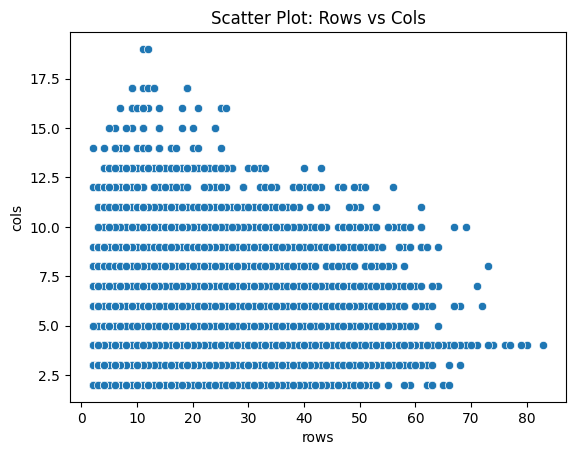

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="rows", y="cols")
plt.title("Scatter Plot: Rows vs Cols")
plt.show()


In [19]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88441 entries, 0 to 88440
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rows    88441 non-null  int64 
 1   cols    88441 non-null  int64 
 2   image   88441 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.0+ MB


,rows,cols
count,88441.000000,88441.000000
mean,12.069594,4.365113
std,9.858092,1.928948
min,2.000000,2.000000
25%,6.000000,3.000000
50%,9.000000,4.000000
75%,14.000000,5.000000
max,83.000000,19.000000


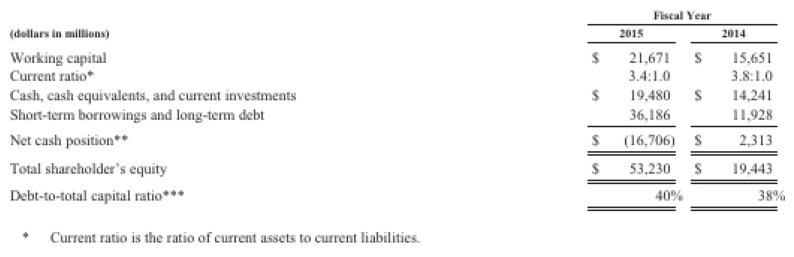

In [31]:
import matplotlib.pyplot as plt

image = Image.open(io.BytesIO(df[df['rows']==9].iloc[1]['image']['bytes']))

plt.figure(figsize=(10,10))   # make display area bigger
plt.imshow(image)
plt.axis('off')
plt.show()




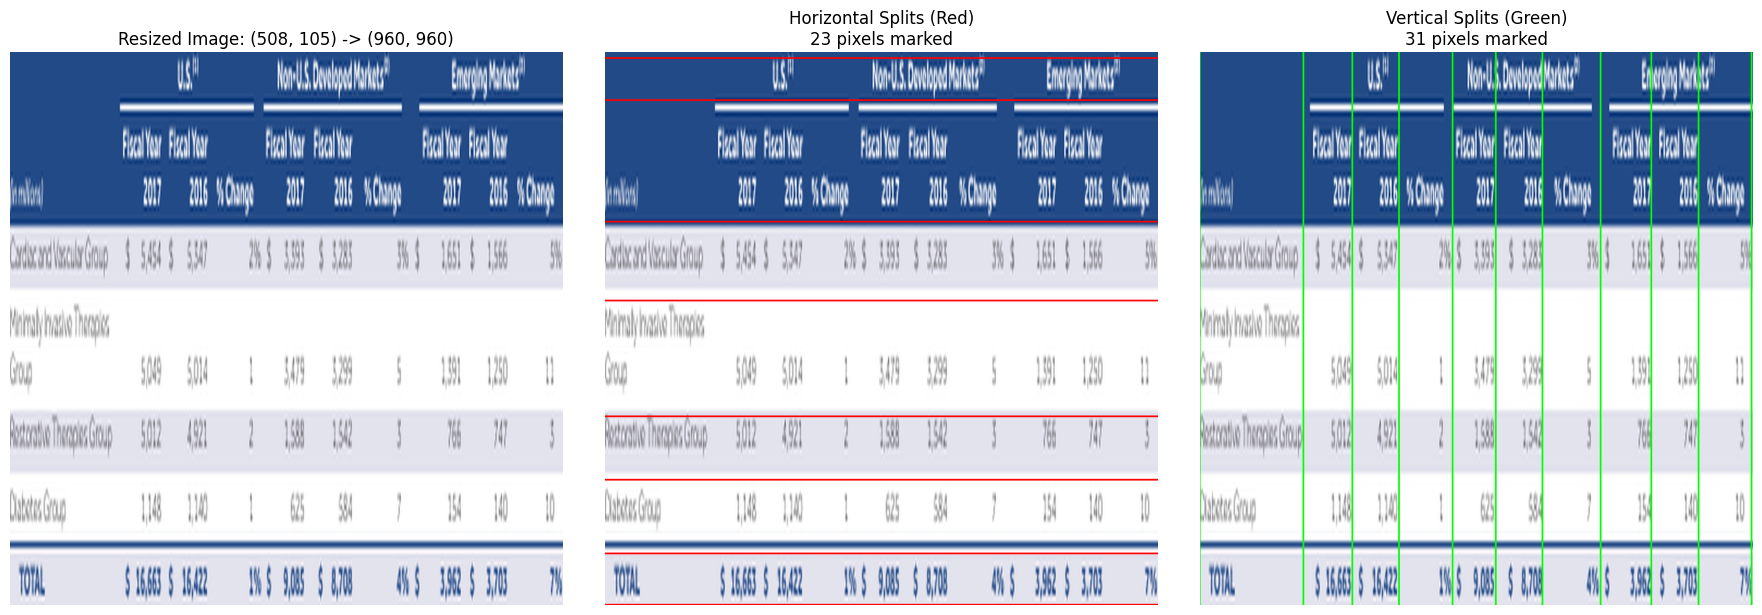

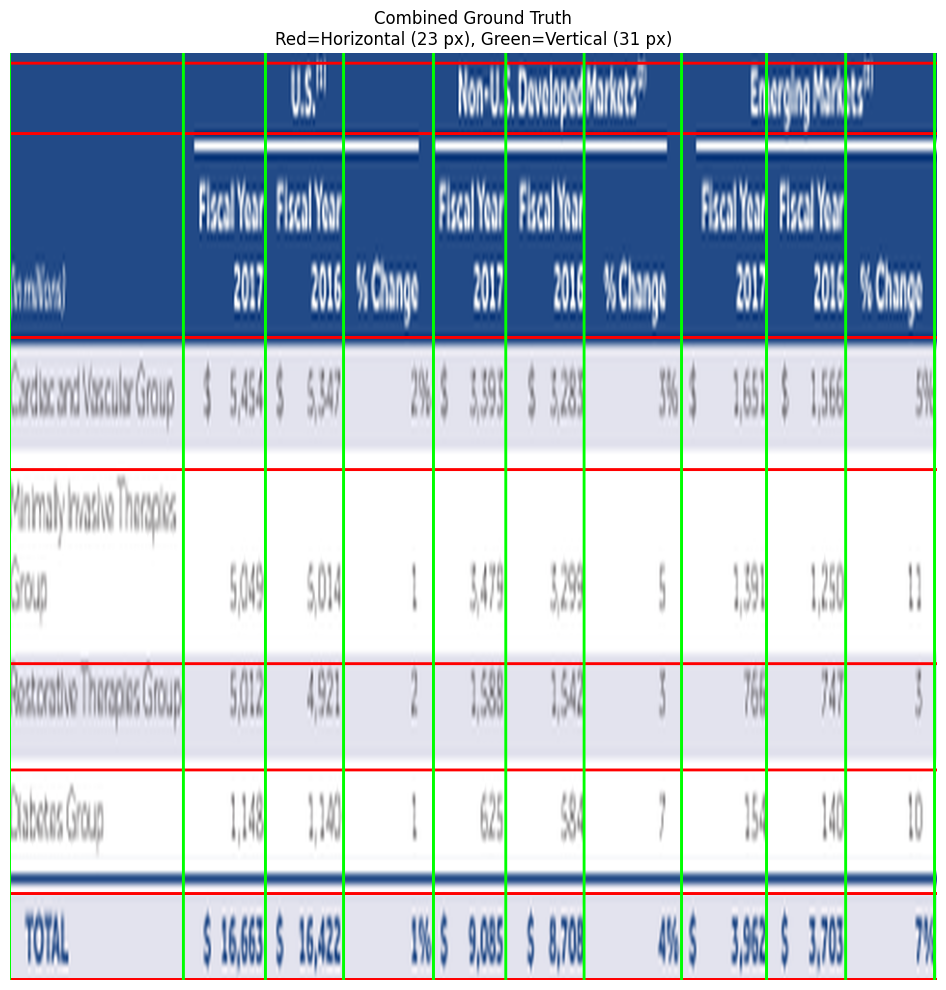

In [65]:
import random
import numpy as np
from PIL import Image, ImageDraw

def augment_image_with_whitening(
    image,
    row_splits,
    col_splits,
    orig_height,
    orig_width,
    target_size=960,
    augment=False,
    aug_row_prob=0.3,      # prob of whitening a row split
    aug_col_prob=0.3,      # prob of whitening a col split
    aug_width_factor_range=(0.5, 1.5),  # how wide to make the whitened area
    aug_offset_range=(-5, 5)  # offset from actual split position
):
    """
    whiten out split regions in the image to make training more robust.
    ground truth stays clean, only image gets damaged.
    
    returns: augmented PIL Image
    """
    if not augment:
        return image
    
    # convert to numpy for easier manipulation
    img_array = np.array(image)
    
    # scale splits to original image size (before resize)
    # row_splits and col_splits are in original coords
    
    # randomly select which row splits to whiten
    for row_y in row_splits:
        if random.random() < aug_row_prob:
            # add random offset
            offset = random.randint(*aug_offset_range)
            actual_y = int(row_y + offset)
            actual_y = max(0, min(orig_height - 1, actual_y))
            
            # random width for whitening
            base_width = 3  # base whitening width
            width_factor = random.uniform(*aug_width_factor_range)
            width = int(base_width * width_factor)
            width = max(1, width)
            
            # whiten the region
            for dy in range(-width//2, width//2 + 1):
                y_pos = actual_y + dy
                if 0 <= y_pos < orig_height:
                    img_array[y_pos, :] = 255  # white out entire row
    
    # randomly select which column splits to whiten
    for col_x in col_splits:
        if random.random() < aug_col_prob:
            offset = random.randint(*aug_offset_range)
            actual_x = int(col_x + offset)
            actual_x = max(0, min(orig_width - 1, actual_x))
            
            base_width = 3
            width_factor = random.uniform(*aug_width_factor_range)
            width = int(base_width * width_factor)
            width = max(1, width)
            
            # whiten the region
            for dx in range(-width//2, width//2 + 1):
                x_pos = actual_x + dx
                if 0 <= x_pos < orig_width:
                    img_array[:, x_pos] = 255  # white out entire column
    
    return Image.fromarray(img_array)


def get_ground_truth(
    image, 
    cells, 
    otsl, 
    split_width=5,
    augment=False,
    aug_row_prob=0.3,
    aug_col_prob=0.3,
    aug_width_factor_range=(0.5, 1.5),
    aug_offset_range=(-5, 5)
):
    """
    parse OTSL to derive row/column split positions.
    this is the groundtruth for split model training.
    
    optionally augments the IMAGE (not ground truth) by whitening split areas.
    
    Args:
        image: PIL Image
        cells: nested list - cells[0] contains actual cell data
        otsl: OTSL token sequence
        split_width: width of split regions in pixels (default: 5)
        augment: enable image whitening augmentation
        aug_row_prob: probability of whitening a row split area
        aug_col_prob: probability of whitening a column split area
        aug_width_factor_range: multiplier range for whitening width
        aug_offset_range: pixel offset range from actual split position
        
    Returns:
        augmented_image: PIL Image (possibly whitened)
        horizontal_gt: ground truth for row splits
        vertical_gt: ground truth for column splits
    """
    orig_width, orig_height = image.size
    target_size = 960
    
    # cells is nested - extract actual list
    cells_flat = cells[0]
    
    # parse OTSL to build 2D grid
    grid = []
    current_row = []
    cell_idx = 0
    
    for token in otsl:
        if token == 'nl':
            if current_row:
                grid.append(current_row)
                current_row = []
        elif token == 'fcel' or token == 'ecel':
            current_row.append({'type': token, 'cell_idx': cell_idx})
            cell_idx += 1
        elif token in ['lcel', 'ucel', 'xcel']:
            current_row.append({'type': token, 'cell_idx': None})
    
    if current_row:
        grid.append(current_row)
    
    # derive row splits - max y2 for each row
    row_splits = []
    for row in grid:
        row_cell_indices = [item['cell_idx'] for item in row if item['cell_idx'] is not None]
        if row_cell_indices:
            max_y = max(cells_flat[i]['bbox'][3] for i in row_cell_indices)
            row_splits.append(max_y)
    
    # derive column splits - max x2 for each column
    num_cols = len(grid[0]) if grid else 0
    col_splits = []
    for col_idx in range(num_cols):
        col_max_x = []
        for row in grid:
            if col_idx < len(row) and row[col_idx]['cell_idx'] is not None:
                next_is_lcel = (col_idx + 1 < len(row) and row[col_idx + 1]['type'] == 'lcel')
                if not next_is_lcel:
                    cell_id = row[col_idx]['cell_idx']
                    col_max_x.append(cells_flat[cell_id]['bbox'][2])
        if col_max_x:
            col_splits.append(max(col_max_x))
    
    # augment IMAGE by whitening split regions (before removing last splits)
    augmented_image = augment_image_with_whitening(
        image,
        row_splits[:-1] if len(row_splits) > 0 else [],  # exclude table boundary
        col_splits[:-1] if len(col_splits) > 0 else [],  # exclude table boundary
        orig_height,
        orig_width,
        target_size=target_size,
        augment=augment,
        aug_row_prob=aug_row_prob,
        aug_col_prob=aug_col_prob,
        aug_width_factor_range=aug_width_factor_range,
        aug_offset_range=aug_offset_range
    )
    
    # remove last splits (table boundaries)
    row_splits = row_splits[:-1]
    col_splits = col_splits[:-1]
    
    # scale to target size for ground truth
    y_scaled = [(y * target_size / orig_height) for y in row_splits]
    x_scaled = [(x * target_size / orig_width) for x in col_splits]
    
    # init ground truth arrays (these stay CLEAN)
    horizontal_gt = [0] * target_size
    vertical_gt = [0] * target_size
    
    # compute table bbox
    all_x1 = [c['bbox'][0] for c in cells_flat]
    all_y1 = [c['bbox'][1] for c in cells_flat]
    all_x2 = [c['bbox'][2] for c in cells_flat]
    all_y2 = [c['bbox'][3] for c in cells_flat]
    table_bbox = [min(all_x1), min(all_y1), max(all_x2), max(all_y2)]
    table_y1 = int(round(table_bbox[1] * target_size / orig_height))
    table_y2 = int(round(table_bbox[3] * target_size / orig_height))
    table_x1 = int(round(table_bbox[0] * target_size / orig_width))
    table_x2 = int(round(table_bbox[2] * target_size / orig_width))
    
    # mark table bbox boundaries
    for offset in range(split_width):
        pos = table_y1 + offset
        if 0 <= pos < target_size:
            horizontal_gt[pos] = 1
    
    for offset in range(split_width):
        pos = table_y2 - offset
        if 0 <= pos < target_size:
            horizontal_gt[pos] = 1
    
    for offset in range(split_width):
        pos = table_x1 + offset
        if 0 <= pos < target_size:
            vertical_gt[pos] = 1
    
    for offset in range(split_width):
        pos = table_x2 - offset
        if 0 <= pos < target_size:
            vertical_gt[pos] = 1
    
    # mark split regions (clean ground truth)
    for y in y_scaled:
        y_int = int(round(y))
        if 0 <= y_int < target_size:
            for offset in range(split_width):
                pos = y_int + offset
                if 0 <= pos < target_size:
                    horizontal_gt[pos] = 1
    
    for x in x_scaled:
        x_int = int(round(x))
        if 0 <= x_int < target_size:
            for offset in range(split_width):
                pos = x_int + offset
                if 0 <= pos < target_size:
                    vertical_gt[pos] = 1
    
    return augmented_image, horizontal_gt, vertical_gt




import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

def visualize_ground_truth(sample, target_size=960,split_width=5,augment=False):
    """
    Visualize ground truth splits overlaid on the image.
    
    Args:
        sample: dataset sample with 'image', 'cells', 'otsl' keys
        target_size: target dimension for ground truth (default 960)
    """
    # Get ground truth
    img,horizontal_gt, vertical_gt = get_ground_truth(sample['image'],sample['cells'],sample['otsl'],split_width=split_width,
                                                  augment=augment,
    aug_row_prob=0.3,  # 30% of row splits get whitened
    aug_col_prob=0.3,  # 30% of col splits get whitened
    aug_width_factor_range=(0.5, 1.5),  # whitening width varies
    aug_offset_range=(-1, 1)  # can be off by ±5 pixels
                                                  )
    
    # Get and resize image
    
    img_resized = img.resize((target_size, target_size), Image.LANCZOS)
    
    # Convert to numpy for visualization
    img_array = np.array(img_resized)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Original resized image
    axes[0].imshow(img_resized)
    axes[0].set_title(f'Resized Image: {img.size} -> {img_resized.size}')
    axes[0].axis('off')
    
    # 2. Image with horizontal splits overlay
    img_h = img_array.copy()
    for y_pos, val in enumerate(horizontal_gt):
        if val == 1:
            img_h[y_pos, :] = [255, 0, 0]  # Red horizontal lines
    
    axes[1].imshow(img_h)
    axes[1].set_title(f'Horizontal Splits (Red)\n{sum(horizontal_gt)} pixels marked')
    axes[1].axis('off')
    
    # 3. Image with vertical splits overlay
    img_v = img_array.copy()
    for x_pos, val in enumerate(vertical_gt):
        if val == 1:
            img_v[:, x_pos] = [0, 255, 0]  # Green vertical lines
    
    axes[2].imshow(img_v)
    axes[2].set_title(f'Vertical Splits (Green)\n{sum(vertical_gt)} pixels marked')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Also create a combined view
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    img_combined = img_array.copy()
    
    # Overlay both splits
    for y_pos, val in enumerate(horizontal_gt):
        if val == 1:
            img_combined[y_pos, :] = [255, 0, 0]  # Red
    
    for x_pos, val in enumerate(vertical_gt):
        if val == 1:
            img_combined[:, x_pos] = [0, 255, 0]  # Green
    
    ax.imshow(img_combined)
    ax.set_title(f'Combined Ground Truth\nRed=Horizontal ({sum(horizontal_gt)} px), Green=Vertical ({sum(vertical_gt)} px)')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# # Test the visualization
# for i in range(100):
#     clear_output(wait=True)
#     visualize_ground_truth(ds['train'][i])
#     time.sleep(1)


# for i in range(1000,5000,5):
#     clear_output(wait=True)
#     print(i)
#     visualize_ground_truth(ds['train'][i],split_width=3,augment=False)
#     time.sleep(1)

visualize_ground_truth(ds['train'][3],split_width=3,augment=False)





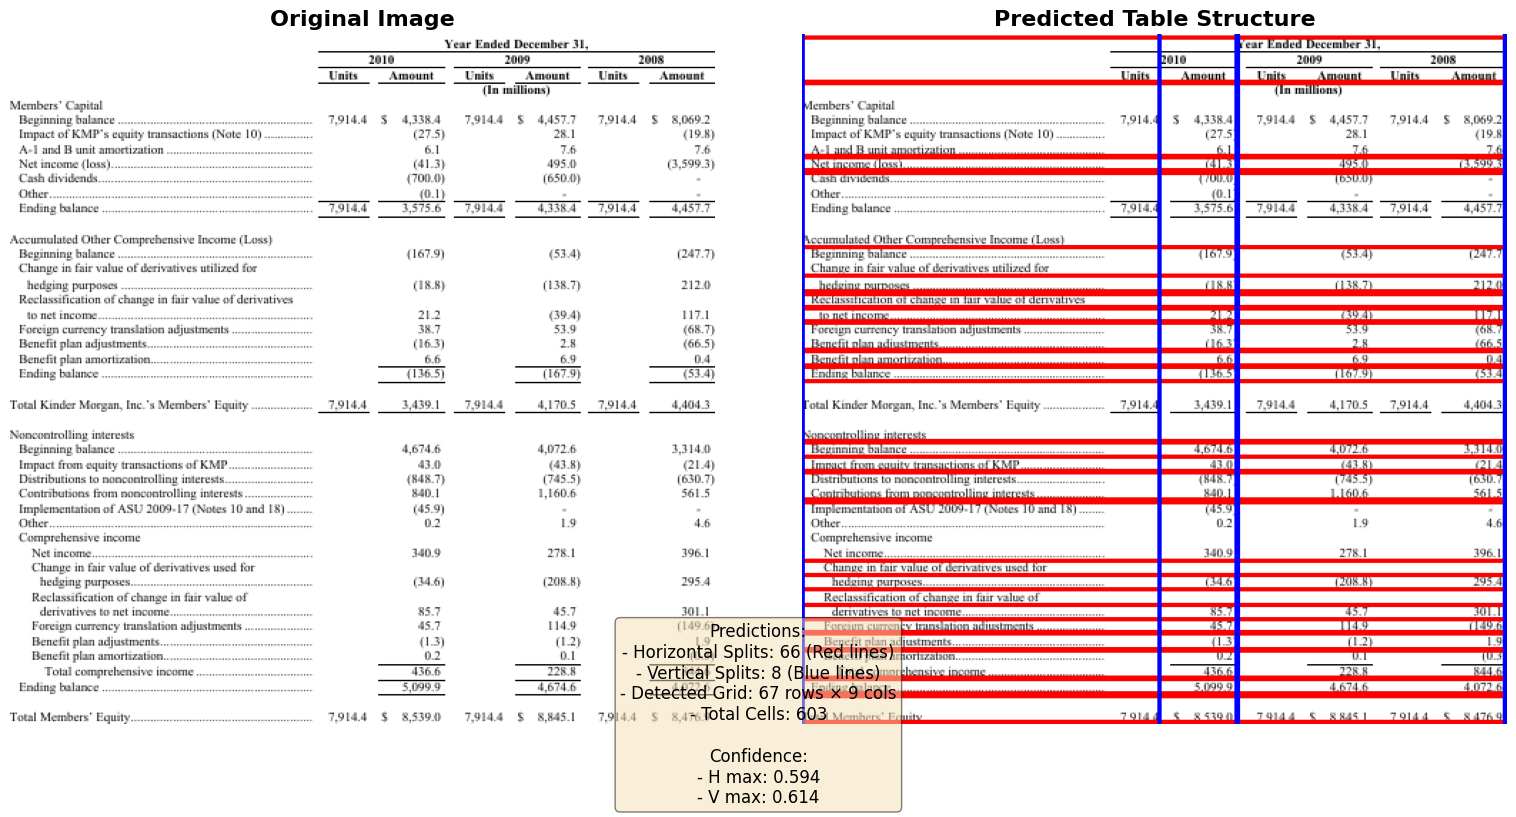


Prediction Results:
Grid Structure: 67 rows × 9 columns
Total Cells: 603

Split Detection:
  Horizontal: 66 splits (confidence: 0.594)
  Vertical: 8 splits (confidence: 0.614)



In [62]:
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
from split_model import SplitModel
from torchvision import transforms

model_path='best_split_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SplitModel().to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def predict_and_visualize(pil_image, threshold=0.5):
    """
    Takes a PIL image, predicts table splits, and visualizes with matplotlib
    
    Args:
        pil_image: PIL Image object
        model_path: path to trained model
        threshold: threshold for binary split detection
    """

    
    # Prepare image
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((960, 960)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    image_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        h_pred, v_pred = model(image_tensor)
        h_pred = h_pred.squeeze(0).cpu()
        v_pred = v_pred.squeeze(0).cpu()
    
    # Apply threshold
    h_binary = (h_pred > threshold).float()
    v_binary = (v_pred > threshold).float()
    
    # Count splits
    h_splits = int(h_binary.sum().item())
    v_splits = int(v_binary.sum().item())
    num_rows = h_splits + 1
    num_cols = v_splits + 1
    
    # Draw lines on image
    W, H = pil_image.size
    vis_image = pil_image.copy()
    draw = ImageDraw.Draw(vis_image)
    
    # Draw horizontal splits (red)
    for y in range(960):
        if h_binary[y] == 1:
            y_scaled = int(y * H / 960)
            draw.line([(0, y_scaled), (W, y_scaled)], fill='red', width=3)
    
    # Draw vertical splits (blue)
    for x in range(960):
        if v_binary[x] == 1:
            x_scaled = int(x * W / 960)
            draw.line([(x_scaled, 0), (x_scaled, H)], fill='blue', width=3)
    
    # Visualize with matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original image
    axes[0].imshow(pil_image)
    axes[0].set_title('Original Image', fontsize=16, fontweight='bold')
    axes[0].axis('off')
    
    # Predicted splits
    axes[1].imshow(vis_image)
    axes[1].set_title('Predicted Table Structure', fontsize=16, fontweight='bold')
    axes[1].axis('off')
    
    # Add info text
    info_text = f"""
Predictions:
- Horizontal Splits: {h_splits} (Red lines)
- Vertical Splits: {v_splits} (Blue lines)
- Detected Grid: {num_rows} rows × {num_cols} cols
- Total Cells: {num_rows * num_cols}

Confidence:
- H max: {h_pred.max():.3f}
- V max: {v_pred.max():.3f}
    """.strip()
    
    plt.figtext(0.5, 0.02, info_text, ha='center', fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()
    
    # Print scores
    print(f"\n{'='*50}")
    print(f"Prediction Results:")
    print(f"{'='*50}")
    print(f"Grid Structure: {num_rows} rows × {num_cols} columns")
    print(f"Total Cells: {num_rows * num_cols}")
    print(f"\nSplit Detection:")
    print(f"  Horizontal: {h_splits} splits (confidence: {h_pred.max():.3f})")
    print(f"  Vertical: {v_splits} splits (confidence: {v_pred.max():.3f})")
    print(f"{'='*50}\n")
    
    return h_splits, v_splits, num_rows, num_cols


# Example usage:
if __name__ == "__main__":
    test_image = ds['train'][1520]['image']
    # test_image = Image.open('your_table_image.png')
    h_splits, v_splits, rows, cols = predict_and_visualize(test_image)